In [1]:
# Based on Google's Udacity Deep Learning course, Assignments 1-4

%reload_ext autoreload
%autoreload 1
%matplotlib inline
import matplotlib.pyplot as plt

import sys
import os
import warnings
assert os.path.basename(os.getcwd()) == 'notebooks', os.path.basename(os.getcwd())
code_dir = os.path.join(os.getcwd(), os.pardir, 'code')
if code_dir not in sys.path:
    sys.path.append(code_dir)
    os.environ['PYTHONPATH'] = os.environ.get('PYTHONPATH', '') + os.pathsep + code_dir
model_dir = os.path.join(os.getcwd(), os.pardir, 'models')
data_dir = os.path.join(os.getcwd(), os.pardir, 'data')
   
import keras
%aimport keras_util

Using TensorFlow backend.


In [2]:
from keras.utils import get_file
import string

def fullpath_listdir(dirname):
    return [os.path.join(dirname, fname) for fname in os.listdir(dirname)]    

def get_notmnist_tgz(base, expected_count, expected_classes):
    notmnist_origin = 'https://commondatastorage.googleapis.com/books1000/'
    subdir = 'notmnist'
    target = os.path.join(data_dir, subdir, base)
    if os.path.isdir(target):
        classdirs = fullpath_listdir(target)
        num_class_files = [len(os.listdir(classdir)) for classdir in classdirs]
        all_examples_present = all(num_files >= expected_count for num_files in num_class_files)
        all_classes_present = all(i in os.listdir(target) for i in expected_classes)
        if all_classes_present and all_examples_present:
            print(base, 'already extracted')
            return target
    ext = '.tar.gz'
    get_file(base + ext, notmnist_origin + base + ext, cache_dir=data_dir, cache_subdir=subdir, extract=True)
    return target

classes = string.ascii_uppercase[:10]
train_dir = get_notmnist_tgz('notMNIST_large', 50000, classes)
test_dir = get_notmnist_tgz('notMNIST_small', 1800, classes)

notMNIST_large already extracted
notMNIST_small already extracted


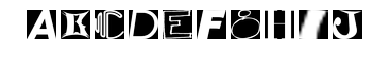

images are 28x28


In [3]:
import numpy as np
classdirs = fullpath_listdir(train_dir)
classdirs.sort()
np.random.seed(1234)
selected_images = [np.random.choice(fullpath_listdir(classdir)) for classdir in classdirs]

from matplotlib.image import imread

# https://stackoverflow.com/questions/36006136/
fig = plt.figure()
for i, f in enumerate(selected_images, start=1):
    ax = fig.add_subplot(1, len(selected_images), i)
    plt.imshow(imread(f), cmap='Greys_r')
    plt.axis('off')

plt.show()

imheight, imwidth = imread(selected_images[0]).shape
print('images are {}x{}'.format(imwidth, imheight))

### Raw Data Ingestion

Load all the pictures as greyscale matrices, and deduplicate exact matches

In [4]:
from keras.preprocessing.image import img_to_array, load_img
import multiprocessing
import contextlib
from sklearn.preprocessing import MultiLabelBinarizer
from joblib import Memory

onehot = MultiLabelBinarizer().fit(classes)

def img_from_file(fname):
    im = load_img(fname, grayscale=True, target_size=(imheight, imwidth))
    return img_to_array(im, data_format='channels_last')

train_classdirs = fullpath_listdir(train_dir)

def no_rows(*shape):
    shape_tup = (0, ) + tuple(shape)
    return np.empty(shape=shape_tup, dtype=np.float32)


def labelled_img(fname):
    try:
        label = os.path.basename(os.path.dirname(fname))
        x = img_from_file(fname).reshape(1, imheight, imwidth, 1)
        y = onehot.transform(label).astype(np.float32)
        return x, y
    except IOError as e:
        print(e)
    return no_rows(28, 28, 1), no_rows(10)

memory = Memory(cachedir=os.path.join(train_dir, os.path.pardir), verbose=2)

@memory.cache
def load_raw(directory):
    all_fnames = [
        f for clsdir in fullpath_listdir(directory)
        if os.path.isdir(clsdir) for f in fullpath_listdir(clsdir)
    ]
    with contextlib.closing(
            multiprocessing.Pool(multiprocessing.cpu_count())) as pool:
        xy = pool.map(labelled_img, all_fnames, chunksize=100)
        return tuple(np.vstack(ls) for ls in zip(*xy))

In [5]:
import contexttimer
from tabulate import tabulate

with contexttimer.Timer() as train_time:
    trainx, trainy = load_raw(train_dir)
    
with contexttimer.Timer() as test_time:
    testx, testy = load_raw(test_dir)

print(tabulate(
    [['train', trainx.shape, trainy.shape, train_time.elapsed],
     ['test', testx.shape, testy.shape, test_time.elapsed]],
    ['data set', 'x {}'.format(trainx.dtype), 'y {}'.format(trainy.dtype), 'load time'],
    tablefmt='grid'))

[Memory]    0.0s, 0.0min: Loading load_raw...
[Memory]    0.8s, 0.0min: Loading load_raw...
+------------+---------------------+--------------+-------------+
| data set   | x float32           | y float32    |   load time |
+============+=====================+==============+=============+
| train      | (529114, 28, 28, 1) | (529114, 10) |   0.819602  |
+------------+---------------------+--------------+-------------+
| test       | (18724, 28, 28, 1)  | (18724, 10)  |   0.0313135 |
+------------+---------------------+--------------+-------------+


In [6]:
# Deduplicate exactly-equal images
@memory.cache
def unique_rows(matrix_name):
    nparr = eval(matrix_name)
    assert nparr.ndim > 1
    matrix = nparr.reshape(len(nparr), -1)
    _, ind = np.unique(matrix, axis=0, return_index=True)
    return ind

unique_ind = unique_rows('trainx')
print('dedup reduced training size from {} to {}'.format(len(trainx), len(unique_ind)))
trainx, trainy = trainx[unique_ind], trainy[unique_ind]

[Memory]    0.9s, 0.0min: Loading unique_rows...
dedup reduced training size from 529114 to 461946


In [7]:
from sklearn.model_selection import train_test_split

train_and_validx, train_and_validy = trainx, trainy
trainx, validx, trainy, validy = train_test_split(trainx, trainy, test_size=0.3, random_state=5678)

### LR baseline

In [18]:
import keras.backend as K
from keras.layers import *
from keras.models import Sequential, Model

In [9]:
# Drop down to tf to use scipy optimization wrapper
# Very slow to train unless using tnc

from keras.objectives import categorical_crossentropy
import tensorflow as tf

def get_logistic(use_cached=True):
    K.clear_session()
    keras_util.seedall()

    inputs = K.constant(train_and_validx)
    logistic = Sequential(
        [Flatten(input_shape=train_and_validx.shape[1:]),
         Dense(10, activation='softmax', name='dense')])
    if os.path.isfile('weights') and use_cached:
        print('loading cached weights')
        logistic.load_weights('weights')
    else:
        outputs = logistic(inputs)
        labels = K.constant(train_and_validy)

        loss = K.mean(categorical_crossentropy(labels, outputs))
        acc = K.mean(
                K.equal(K.argmax(labels, axis=1),
                        K.argmax(outputs, axis=1)))
        opt = tf.contrib.opt.ScipyOptimizerInterface(
            loss, method='tnc', options={'maxiter': 10000, 'disp': True})
        
        tb = keras.callbacks.TensorBoard(log_dir='logs')
        tb.set_model(logistic)

        def make_loss_callback(step):
            epoch = 0
            def loss_callback(loss, acc):
                nonlocal epoch, tb
                logs = {'loss': loss, 'acc': acc}
                tb.on_epoch_end(epoch, logs)
                epoch += 1
                if epoch % step == 0 or epoch == 1:
                    print('step {:4d} loss {:7.4f} acc {:6.4f}'.format(epoch, loss, acc))
            return loss_callback

        K.get_session().run(tf.global_variables_initializer())
        opt.minimize(
            K.get_session(), fetches=[loss, acc], loss_callback=make_loss_callback(500))
        tb.on_train_end(None)

        logistic.save('weights')
        
    logistic.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
    return logistic

with keras_util.rectime('logistic training took {:4.0f} sec'):
    with keras_util.cd(os.path.join(model_dir, 'notmnist', 'logistic')):
        logistic = get_logistic()
keras_util.evaluate(logistic, testx, testy, batch_size=len(testx))

loading cached weights
logistic training took    5 sec
18724/18724 [==============================] - 1s


{'acc': 0.89756464958190918, 'loss': 1.6411033868789673}

### Resnet-like architecture

In [19]:
from keras.applications.resnet50 import conv_block, identity_block

def greyscale_resnet(input_shape, nclasses):
    
    assert len(input_shape) == 3, input_shape
    assert input_shape[-1] == 1, input_shape
    
    img = Input(shape=input_shape, dtype=K.floatx(), name='greyscale_input_img')

    x = Conv2D(64, (7, 7), padding='same', name='conv1')(img)
    x = BatchNormalization(axis=3, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    x = conv_block(x, 3, [64, 64, 128], stage=2, block='conv')
    for i in range(5):
        x = identity_block(x, 3, [64, 64, 128], stage=2, block='id{}'.format(i))
        
    x = conv_block(x, 3, [128, 128, 256], stage=3, block='conv')
    for i in range(5):
        x = identity_block(x, 3, [128, 128, 256], stage=3, block='id{}'.format(i))
    
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(nclasses, activation='softmax', name='fc')(x)
    
    return Model(img, x, name='resnet')

In [20]:
import io

def fresh_resnet():
    K.clear_session()
    keras_util.seedall()

    with keras_util.rectime('generating  {:4.0f} sec'):
        greyres = greyscale_resnet(trainx.shape[1:], len(classes))

    return greyres

f = io.StringIO()
with contextlib.redirect_stdout(f):
    fresh_resnet().summary()
print('\n'.join(f.getvalue().split('\n')[-6:]))

Total params: 1,687,306
Trainable params: 1,677,194
Non-trainable params: 10,112
____________________________________________________________________________________________________



In [21]:
import multigpu

def serial_resnet():
    greyres = fresh_resnet()

    with keras_util.rectime('compiling   {:4.0f} sec'):
        greyres.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])
        
    return greyres

def parallel_resnet():
    greyres = fresh_resnet()

    with keras_util.rectime('parallelize {:4.0f} sec'):
        greyres = multigpu.make_parallel(greyres)

    with keras_util.rectime('compiling   {:4.0f} sec'):
        greyres.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])
    return greyres

In [22]:
from keras.preprocessing.image import ImageDataGenerator

def minibench(model, name, batch_size):
    steps = 16
    gen = ImageDataGenerator().flow(trainx, trainy, batch_size=batch_size, seed=1234)
    with keras_util.rectime('warmup      {:4.0f} sec'):
        model.fit_generator(gen, steps_per_epoch=steps, epochs=1, verbose=0)
    with contexttimer.Timer() as t:
        model.fit_generator(gen, steps_per_epoch=steps, epochs=1)
    expected = int(t.elapsed * len(trainx) / batch_size / steps)
    print('{} expected epoch runtime {} sec'.format(name, expected))

# Only start to see improvement in parallel net around large batches
batch_size = 2048

par_res = parallel_resnet()
minibench(par_res, 'multi-gpu net', batch_size)

ser_res = serial_resnet()
minibench(ser_res, 'serial net', batch_size)

generating     2 sec
parallelize    3 sec
compiling      2 sec
warmup        29 sec
Epoch 1/1
16/16 [==============================] - 8s - loss: 1.3598 - acc: 0.7210     
multi-gpu net expected epoch runtime 87 sec
generating     2 sec
compiling      0 sec
warmup        28 sec
Epoch 1/1
16/16 [==============================] - 16s - loss: 1.1396 - acc: 0.7031    
serial net expected epoch runtime 158 sec


In [23]:
std_gen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
)
perturb_gen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    width_shift_range=0.1,
    height_shift_range=0.1, 
    fill_mode='constant'
)

def fit_generators(x, *gens):
    with warnings.catch_warnings():
        # As of Aug 2017, keras fires a user warning when augmenting greyscale
        # images, even though its API supports it. The spurious warning has
        # been fixed but the fix isn't released yet.
        warnings.filterwarnings("ignore", message='Expected input to be images')
        for gen in gens:
            gen.fit(x)
fit_generators(trainx, std_gen, perturb_gen)

net = parallel_resnet()

train_batch_size = 1024
valid_batch_size = 5096
train_gen = perturb_gen.flow(trainx, trainy, batch_size=train_batch_size, seed=5678)
valid_gen = std_gen.flow(validx, validy, batch_size=valid_batch_size, shuffle=False)

generating     2 sec
parallelize    2 sec
compiling      1 sec


In [22]:
with keras_util.rectime('training took {:4.0f} sec'):
    with keras_util.cd(os.path.join(model_dir, 'notmnist', 'residual')):
        if os.path.isfile('weights'):
            print('using cached weights')
            net.load_weights('weights')
        else:
            early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
            lr = keras.callbacks.ReduceLROnPlateau(patience=5)
            checkpoint = keras.callbacks.ModelCheckpoint(
                'weights', monitor='val_loss', save_best_only=True)
            tb = keras.callbacks.TensorBoard(log_dir='logs')
            callbacks = [early_stopping, lr, checkpoint, tb]
            net.fit_generator(
                train_gen,
                verbose=1,
                steps_per_epoch=(len(trainx) // train_batch_size),
                epochs=500,
                callbacks=callbacks,
                validation_data=valid_gen,
                validation_steps=(len(validx) // valid_batch_size))

using cached weights
training took    1 sec


In [24]:
with keras_util.cd(os.path.join(model_dir, 'notmnist', 'residual')):
    net.load_weights('weights')

def to_std(x, y):
    gen = std_gen.flow(x, y, batch_size=len(x), shuffle=False)
    return next(gen)

# post-training (training on train + validation until loss on the
# aggregate set is equal to post-training loss on train) doesn't help much:
# only improves test acc by ~0.0001
print(keras_util.evaluate(net, *to_std(testx, testy), 
                          batch_size=valid_batch_size))

18724/18724 [==============================] - 3s     
{'loss': 0.059234185202003062, 'acc': 0.98328361134833697}


### FAISS image similarity

The below isn't really relevant to the classification problem, just messing around with FAISS to see what the misclassified examples are (and what the nearby features are for it).

Unfortunately, you have to run the cell below with the network defined, then restart the kernel, and use the cached output (without re-creating the network) since TF hogs all GPU memory and needs the  owning python process killed to release it (for FAISS's use).

In [8]:
def get_features(x):
    layers = net.get_layer('resnet').layers
    final_layer = [x for x in layers if x.name.startswith('flatten')][0]
    learned_features = K.function([net.input, K.learning_phase()], [final_layer.output])
    nsplits = max(len(train_and_validx) // valid_batch_size, 1)
    stdx = to_std(x, x)[0]
    splits = np.array_split(stdx, nsplits)
    feats = [learned_features([split, 0])[0] for split in splits]
    return np.concatenate(feats)
    
@memory.cache
def get_training_features():
    return get_features(train_and_validx)

train_matrix = get_training_features()
num_vecs, vec_dim = train_matrix.shape
print('training matrix {}x{}'.format(num_vecs, vec_dim))

@memory.cache
def get_predictions_features():
    stdx = to_std(testx, testy)[0]
    preds = net.predict(stdx, batch_size=valid_batch_size).argmax(axis=1)
    incorr = preds != testy.argmax(axis=1)
    incorr = np.flatnonzero(incorr)
    mislabelled_feats = get_features(stdx[incorr])
    return mislabelled_feats, preds, incorr

mislabelled_feats, preds, incorr = get_predictions_features()
print('mislabelled matrix {}x{}'.format(*mislabelled_feats.shape))

[Memory]    2.1s, 0.0min: Loading get_training_features...
training matrix 461946x4096
[Memory]    5.8s, 0.1min: Loading get_predictions_features...
mislabelled matrix 313x4096


In [9]:
# warning: this takes up 7GB memory on two GPUs.
import faiss

ngpu = keras_util.ngpu()
# faiss uses swig, which fails unless we hold all these objects
# in lists explicitly
resources = [faiss.StandardGpuResources() for i in range(ngpu)]

index = faiss.index_factory(vec_dim, 'IVF{},Flat'.format(128))
index.nprobe = 20
opts = faiss.GpuMultipleClonerOptions()
opts.shard = True
opts.indices_options = faiss.INDICES_CPU
index = faiss.index_cpu_to_gpu_multiple_py(resources, index, opts)

In [10]:
with contexttimer.Timer() as t:
    index.train(train_matrix)
    index.add(train_matrix)
print('Trained image similarity index in {:.2f} sec'.format(t.elapsed))

Trained image similarity index in 9.40 sec


In [11]:
k = 10

with contexttimer.Timer() as t:
    distances, indices = index.search(mislabelled_feats, k)
print('Found top-{} similarity matches for all images in {:.2f} sec'.format(k, t.elapsed))

Found top-10 similarity matches for all images in 2.99 sec


first image is mistake, next 10 are nearest to it in training set
label is <true label>/<guessed label>


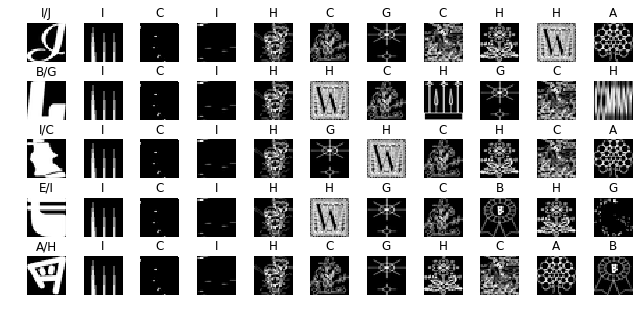

In [29]:
width = k + 1
height = 5
fig = plt.figure(figsize=(width, height))
np.random.seed(1234)
selected_mistakes = np.random.choice(np.arange(len(indices)), height)
image_indices = np.concatenate([np.insert(indices[i], 0, incorr[i]) for i in selected_mistakes])
print('first image is mistake, next 10 are nearest to it in training set')
print('label is <true label>/<guessed label>')
for i, image_index in enumerate(image_indices, start=1):
    if i % width == 1:
        im = testx[image_index].reshape(28, 28)
        true = classes[testy[image_index].argmax()]
        guessed = classes[preds[image_index]]
        y = '{}/{}'.format(true, guessed)
    else:
        im = train_and_validx[image_index].reshape(28, 28)
        y = classes[train_and_validy[image_index].argmax()]
    ax = fig.add_subplot(height, width, i)
    plt.imshow(im, cmap='Greys_r')
    plt.title(y)
    plt.axis('off')

plt.subplots_adjust(hspace=.5)
plt.show()

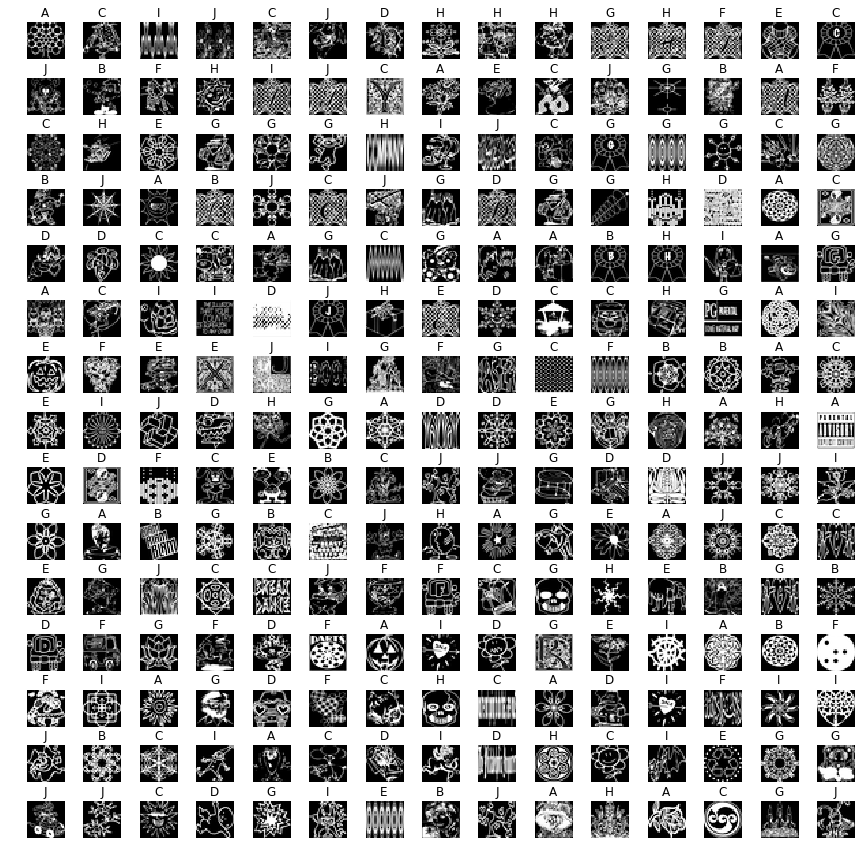

In [31]:
activations = np.fabs(train_matrix).sum(axis=1)
sz = 15
ims = activations.argsort()[:sz ** 2]
width = sz
height = sz
fig = plt.figure(figsize=(width, height))
for i, image_index in enumerate(ims, start=1):
    im = train_and_validx[image_index].reshape(28, 28)
    y = classes[train_and_validy[image_index].argmax()]
    ax = fig.add_subplot(height, width, i)
    plt.imshow(im, cmap='Greys_r')
    plt.title(y)
    plt.axis('off')

plt.subplots_adjust(hspace=.5)
plt.show()